# Downloading and Evaluating Open Images

Downloading Open Images is now easier than ever with the [FiftyOne Dataset Zoo](https://voxel51.com/docs/fiftyone/user_guide/dataset_zoo/index.html)! You can load all three splits of Open Images V6 along with image-level labels, detections, segmentations, and visual relationships.

[Open Images object detection evaluation](https://storage.googleapis.com/openimages/web/index.html) has also been added to [FiftyOne](http://fiftyone.ai). You can now evaluate your object detection models and explore the results directly in FiftyOne.

This walkthrough covers:
* Downloading [Open Images](https://storage.googleapis.com/openimages/web/index.html) from the [FiftyOne Dataset Zoo](https://voxel51.com/docs/fiftyone/user_guide/dataset_zoo/index.html)
* Computing predictions with the [FiftyOne Model Zoo](https://voxel51.com/docs/fiftyone/user_guide/model_zoo/index.html)
* Using [Open Images object detection evaluation](https://storage.googleapis.com/openimages/web/evaluation.html) in FiftyOne to evaluate a model
* Exploring the dataset and evaluation results
* [Visualizing embeddings](https://voxel51.com/docs/fiftyone/user_guide/brain.html#visualizing-embeddings) through [interactive plots](https://voxel51.com/docs/fiftyone/user_guide/plots.html)

**So, what's the takeaway?**

Starting a new ML project takes data and time. The datasets in the FiftyOne Dataset Zoo let you get a jump start with access to publicly available datasets. Open Images in particular is one of the largest datasets for object detections and, most importantly, is curated with images under the [Creative Commons Attribution (CC-BY)](https://creativecommons.org/licenses/by/4.0/) license meaning they can be used by anyone who is interested. 

Additionally, with Open Images-style object detection evaluation in FiftyOne, you can easily evaluate your models. While you can use FiftyOne to compute mAP and PR curves, the best way to improve your model's performance isn't to look at aggregate metrics but instead to get hands-on with your evaluation and visualize how your model performs.

## Setup

If you haven't already, you first need to [install FiftyOne](https://voxel51.com/docs/fiftyone/getting_started/install.html).

In [ ]:
!pip install fiftyone

In this tutorial, we’ll use some TensorFlow models to generate predictions and embeddings, and we’ll use the (default) [UMAP method](https://github.com/lmcinnes/umap) to reduce the dimensionality of embeddings, so we’ll need to install the corresponding packages:

In [ ]:
!pip install tensorflow==1.14 umap-learn

This tutorial will demonstrate the [interactive plotting capabilities](https://voxel51.com/docs/fiftyone/user_guide/plots.html) of FiftyOne.

The recommended way to work with FiftyOne’s interactive plots is in [Jupyter notebooks](https://jupyter.org/) or [JupyterLab](https://jupyterlab.readthedocs.io/en/stable/), because, in these environments, you can leverage the full power of plots by [attaching them to the FiftyOne App](https://voxel51.com/docs/fiftyone/user_guide/plots.html#attaching-plots) and bidirectionally interacting with the plots and the App to identify interesting subsets of your data.

To use interactive plots in Jupyter notebooks, ensure that you have the `ipywidgets` package installed:



In [ ]:
!pip install ipywidgets>=7.5

If you’re working in JupyterLab, refer to [these instructions](https://voxel51.com/docs/fiftyone/user_guide/plots.html#working-in-notebooks) to get setup.


<div class="admonition note">
<p>Support for interactive plots in non-notebook contexts and in <a class="reference external" href="https://colab.research.google.com">Google Colab</a> is coming soon! In the meantime, you can still use FiftyOne's plotting features in those environments, but you must manually call <code class="docutils literal notranslate"><span class="pre">plot.show()</span></code> to update the state of a plot to match the state of a connected session, and any callbacks that would normally be triggered in response to interacting with a plot will not be triggered.</p>
</div>

## Loading FiftyOne and Open Images

In this section, we import [FiftyOne](http://fiftyone.ai/) and load various subsets of Open Images from the [FiftyOne Dataset Zoo](https://voxel51.com/docs/fiftyone/user_guide/dataset_zoo/index.html). 

Note: We will be using Python in this walkthrough, but the FiftyOne Dataset Zoo can also be accessed through [the command line](https://voxel51.com/docs/fiftyone/cli/index.html#fiftyone-dataset-zoo)!

In [1]:
import fiftyone as fo

In [2]:
import fiftyone.zoo as foz

In [3]:
dataset = foz.load_zoo_dataset("open-images", "validation", max_samples=100, seed=51, shuffle=True)

 100% |█████████████████| 100/100 [20.3s elapsed, 0s remaining, 1.8 samples/s]      
Found 100 samples
Dataset info written to '~/fiftyone/open-images/info.json'
Loading 'open-images' split 'validation'
 100% |█████████████████| 100/100 [4.1s elapsed, 0s remaining, 19.6 samples/s]      
Dataset 'open-images-validation-100' created


Lets launch the [FiftyOne App](https://voxel51.com/docs/fiftyone/user_guide/app.html) so we can explore the [dataset](https://voxel51.com/docs/fiftyone/user_guide/using_datasets.html#datasets) we just downloaded


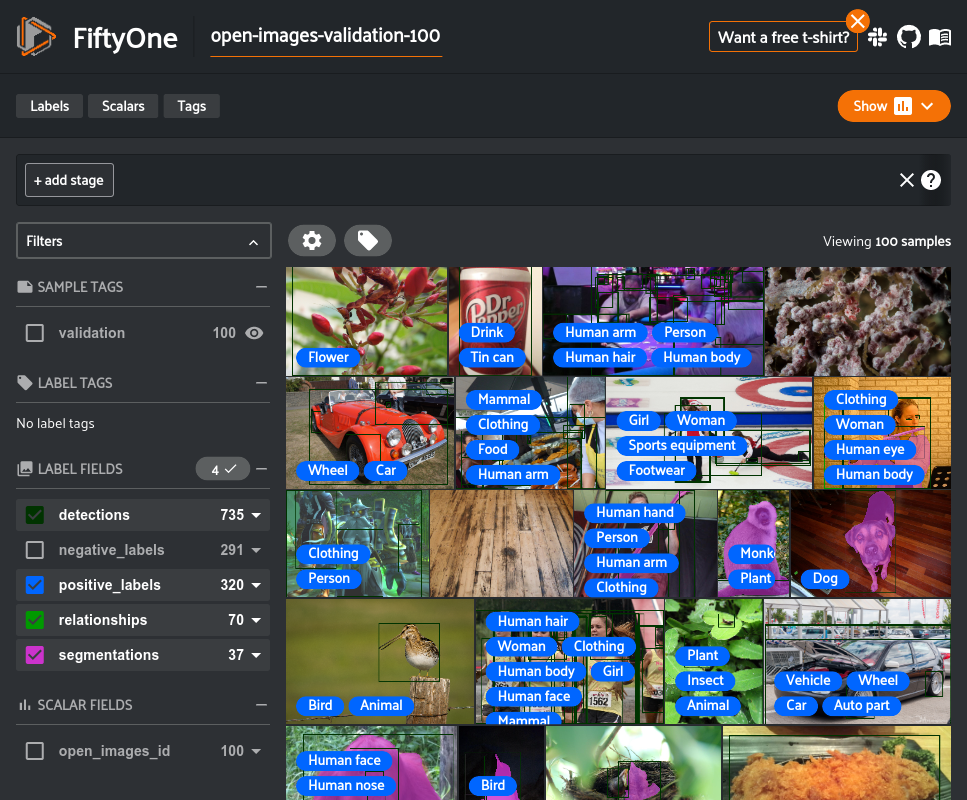

In [4]:
session = fo.launch_app(dataset)

In [5]:
session.freeze() # screenshots App for sharing

Loading Open Images with FiftyOne also automatically adds relevant [labels](https://voxel51.com/docs/fiftyone/user_guide/using_datasets.html#labels) and [metadata](https://voxel51.com/docs/fiftyone/user_guide/using_datasets.html#metadata) like classes, attributes, and a class hierarchy that is used for evaluation.

In [6]:
print(dataset.info.keys())

dict_keys(['hierarchy', 'attributes_map', 'attributes', 'segmentation_classes', 'classes_map'])


In [7]:
import fiftyone.utils.openimages as fouo


fouo.get_attributes()

# fouo.get_classes()
# fouo.get_segmentation_classes()

['(made of)Leather',
 '(made of)Textile',
 'Cry',
 'Jump',
 'Lay',
 'Plastic',
 'Run',
 'Sing',
 'Sit',
 'Smile',
 'Stand',
 'Talk',
 'Transparent',
 'Walk',
 'Wooden']

When loading Open Images from the dataset zoo, there are [parameters unique to that dataset](https://voxel51.com/docs/fiftyone/api/fiftyone.zoo.datasets.base.html#fiftyone.zoo.datasets.base.OpenImagesDataset) letting you specify which subsets of Open Images to download:
* `label_types` - choose between (`"detections", "classifications", "segmentations", "relationships"`) and load samples with those annotations. By default, this will load samples with any combination of annotation types. Specifying `[]` will only load images without any labels.
* `classes` - Only samples with at least one object, segmentation, or image-level label in the specified classes will be downloaded
* `attrs` - Only used when `relationships` is a specified `label_type`. Will include samples if they contain at least one attribute in `attrs` (or one class in `classes`)
* `load_hierarchy` - whether to load the class hierarchy into `dataset.info["hierarchy"]`
* `image_ids` - an array of image ids to download (either lists of `<image_id>`, `<image_id>.<ext>` , or `<split>/<image_id>(.<ext>)`
* `image_ids_file` - a path to a `.txt`, `.csv`, or `.json` file containing image ids to download
* `version` - specify the version of Open Images to load, currently only supports "v6"

Parameters shared with [all other datasets in the zoo](https://voxel51.com/docs/fiftyone/user_guide/dataset_zoo/datasets.html) include:
* `max_samples` - the maximum number of samples to load
* `seed` - seed to use to load random samples if `max_samples` is given
* `shuffle` - whether to shuffle the samples being loaded if `max_samples` is given

Let's use some of these parameters to download a 100 sample subset of Open Images containing segmentations and image-level labels for the classes "Burrito", "Cheese", and "Popcorn".

In [8]:
dataset = foz.load_zoo_dataset(
    "open-images", 
    "validation", 
    label_types=["segmentations", "classifications"], 
    classes = ["Burrito", "Cheese", "Popcorn"],
    max_samples=100,
    seed=51,
    shuffle=True,
    dataset_name="open-images-food",
)

 100% |█████████████████| 100/100 [11.4s elapsed, 0s remaining, 12.3 samples/s]      
Found 100 samples
Dataset info written to '~/fiftyone/open-images/info.json'
Loading 'open-images' split 'validation'
 100% |█████████████████| 100/100 [10.1s elapsed, 0s remaining, 9.9 samples/s]      
Dataset 'open-images-food' created



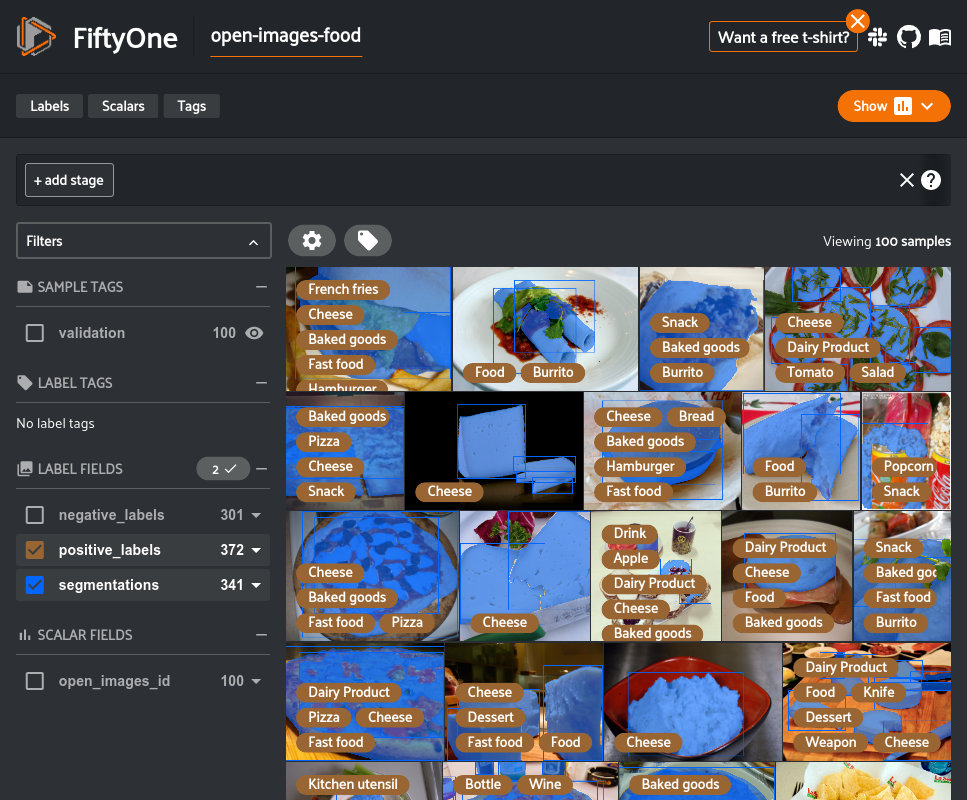

In [9]:
session.dataset = dataset

In [10]:
session.freeze() # screenshots App for sharing

We can do the same for visual relationships. For example we can download only samples that contain a relationship with the "Wooden" attribute.

In [11]:
dataset = foz.load_zoo_dataset(
    "open-images",
    "validation", 
    label_types=["relationships"], 
    attrs = ["Wooden"],
    max_samples=100,
    seed=51,
    shuffle=True,
    dataset_name="open-images-relationships", 
)

3 samples found, downloading the remaining 97
 100% |███████████████████| 97/97 [11.0s elapsed, 0s remaining, 9.7 samples/s]       
Found 100 samples
Dataset info written to '~/fiftyone/open-images/info.json'
Loading 'open-images' split 'validation'
 100% |█████████████████| 100/100 [1.6s elapsed, 0s remaining, 63.2 samples/s]         
Dataset 'open-images-relationships' created



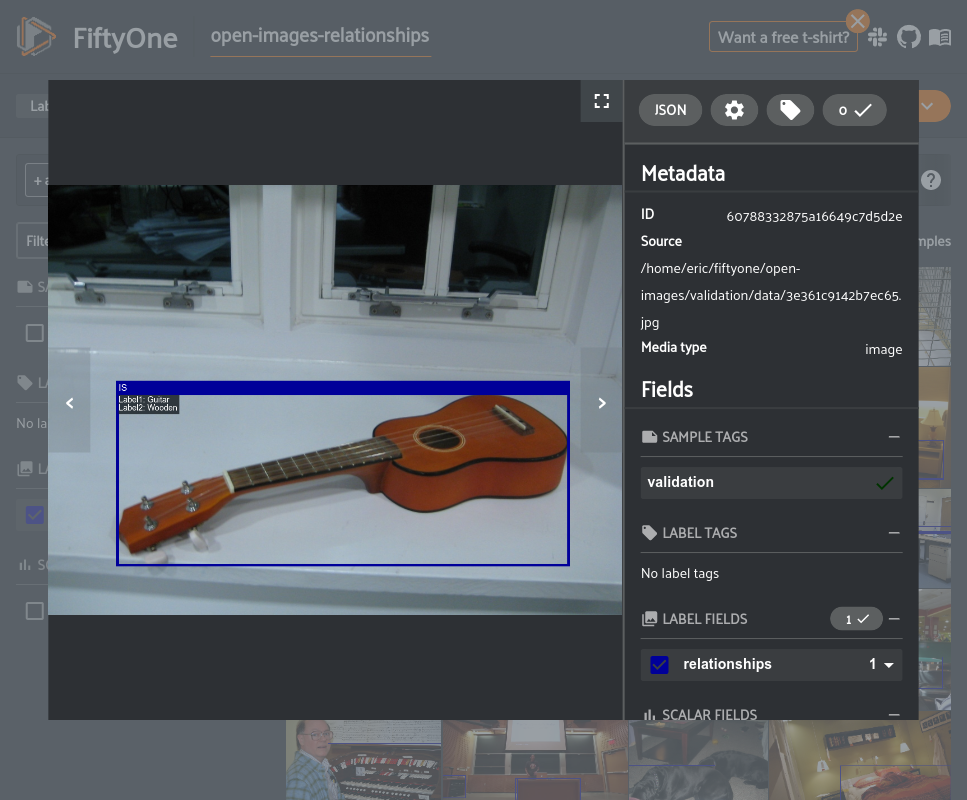

In [12]:
session.dataset = dataset

In [13]:
session.freeze() # screenshots App for sharing

As a basis for the rest of this walkthrough, let's download a subset of Open Images containing dog and cat objects on which we can evaluate a model.

To ensure that we have exactly the same number of labels for each class, let's download two subsets, one for dogs and one for cats, and merge them together.

In [14]:
dataset = foz.load_zoo_dataset(
    "open-images", 
    "validation", 
    label_types=["detections", "classifications"], 
    classes = ["Cat"],
    max_samples=250,
    seed=51,
    shuffle=True,
    dataset_name = "open-images-cat-dog"
)

dog_subset = foz.load_zoo_dataset(
    "open-images", 
    "validation", 
    label_types=["detections", "classifications"], 
    classes = ["Dog"],
    max_samples=250,
    seed=51,
    shuffle=True,
    dataset_name = "dog-subset"
)

1 samples found, downloading the remaining 249
 100% |█████████████████| 249/249 [27.7s elapsed, 0s remaining, 7.6 samples/s]       
Found 250 samples
Dataset info written to '~/fiftyone/open-images/info.json'
Loading 'open-images' split 'validation'
 100% |█████████████████| 250/250 [4.3s elapsed, 0s remaining, 63.9 samples/s]      
Dataset 'open-images-cat-dog' created
5 samples found, downloading the remaining 245
 100% |█████████████████| 245/245 [29.8s elapsed, 0s remaining, 6.0 samples/s]       
Found 250 samples
Dataset info written to '~/fiftyone/open-images/info.json'
Loading 'open-images' split 'validation'
 100% |█████████████████| 250/250 [4.6s elapsed, 0s remaining, 60.7 samples/s]      
Dataset 'dog-subset' created


In [15]:
# Merge the samples together into the same dataset
sample_ids = dataset.merge_samples(dog_subset)


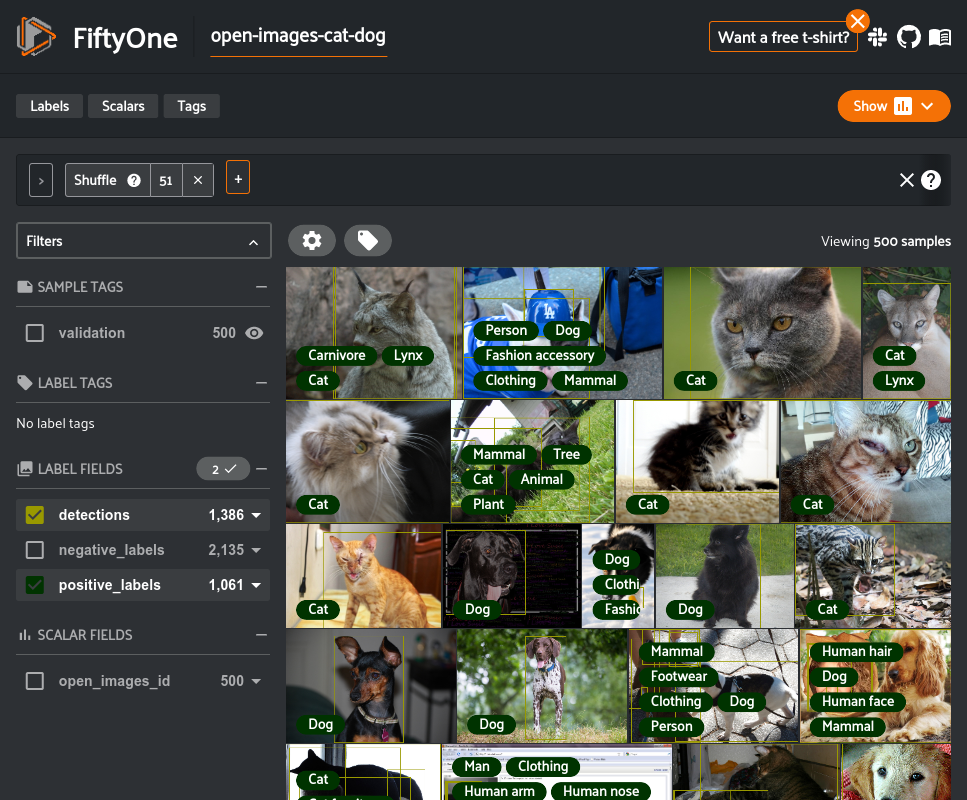

In [16]:
session = fo.launch_app(dataset)

In [17]:
session.freeze() # screenshots App for sharing

## Open Images object detection evaluation

[FiftyOne](http://fiftyone.ai/) supports Open Images-style [object detection evaluation](https://voxel51.com/docs/fiftyone/user_guide/evaluation.html).

This section produces object detection predictions from a model in the [FiftyOne Model Zoo](https://voxel51.com/docs/fiftyone/user_guide/model_zoo/index.html) and evaluates them with FiftyOne.

The FiftyOne evaluation is much more flexible than [other evaluation APIs](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/evaluation_protocols.md) that produce only aggregate performance metrics. FiftyOne evaluation also produces label for individual detections as true positive, false positive, and false negative allowing you to explore your model results and easily find failure modes of your model or even [annotation mistakes](https://voxel51.com/docs/fiftyone/user_guide/brain.html#label-mistakes).

### Generate predictions

The [FiftyOne Model Zoo](https://voxel51.com/docs/fiftyone/user_guide/model_zoo/index.html) does not yet contain models trained on Open Images, so instead we will be evaluating on a model trained on [MS-COCO](https://cocodataset.org/#home) and evaluate classes that overlap between [COCO](https://gist.github.com/AruniRC/7b3dadd004da04c80198557db5da4bda) and Open Images (like the class "Dog").

The model we are using requires [TensorFlow Models](https://github.com/tensorflow/models), which we can easily install using `eta`, a package provided with FiftyOne.

In [ ]:
!eta install models

In [18]:
model = foz.load_zoo_model("ssd-mobilenet-v1-coco-tf")

In [19]:
dataset.apply_model(model, label_field="predictions", confidence_thresh=0.5)

 100% |█████████████████| 500/500 [1.8m elapsed, 0s remaining, 5.1 samples/s]      


The dataset now contains all Open Images ground truth objects as well as all model predictions. However, we are only interested in the classes "Cat" and "Dog" for this example, so we will filter out all other labels. We specified these classes when downloading the dataset meaning all images are guaranteed to be related to the classes "Cat" and "Dog", we just need to filter the individual labels.

Since there is a capitalization difference between the class names of Open Images and COCO, we also need to [map the labels](https://voxel51.com/docs/fiftyone/user_guide/using_views.html#modifying-fields) from one schema to the other.

In [20]:
from fiftyone import ViewField as F

oi_classes = ["Dog", "Cat"]
coco_classes = ["dog", "cat"]

eval_view = (
    dataset
    .filter_labels(
        "detections",
        F("label").is_in(oi_classes),
        only_matches=False,
    ).filter_labels(
        "predictions",
        F("label").is_in(coco_classes),
        only_matches=False,
    ).map_labels(
        "predictions", 
        {
            "dog": "Dog",
            "cat": "Cat",
        },
    )
)

### Running evaluation

We can now evaluate on this view in FiftyOne with one line of code. 

[Open Images evaluation](https://storage.googleapis.com/openimages/web/evaluation.html) provides a few additions on top of the evlaution protocol for [Pascal VOC 2010](http://host.robots.ox.ac.uk/pascal/VOC/voc2010/devkit_doc_08-May-2010.pdf):
* You can specify image-level labels, any objects with a class not in either the positive or negative labels is ignored for that sample
* A [class hierarchy](https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy_visualizer/circle.html) can be used to expand ground truth or predicted classes
* Ground truth objects can use the `IsGroupOf` attribute to indicate multiple instances of a class existing within the bounding box

Let's start by running evaluation how it would be done for a model trained on Open Images, with image-level labels and expanded hierarchies.

In [21]:
results = fo.evaluate_detections(
    eval_view,
    pred_field="predictions",
    gt_field="detections",
    pos_label_field="positive_labels",
    neg_label_field="negative_labels",
    hierarchy = dataset.info["hierarchy"],
    method = "open-images",
    expand_pred_hierarchy=True,
)

Evaluating detections...
 100% |█████████████████| 500/500 [10.8s elapsed, 0s remaining, 42.6 samples/s]      


`evaluate_detections` returns a `results` object, in this case 
an`OpenImagesEvaluationResults`. This class provides methods like [`mAP()`](https://voxel51.com/docs/fiftyone/api/fiftyone.utils.eval.coco.html?highlight=map#fiftyone.utils.eval.coco.COCODetectionResults.mAP), [`confusion_matrix()`](https://voxel51.com/docs/fiftyone/api/fiftyone.utils.eval.coco.html?highlight=map#fiftyone.utils.eval.coco.COCODetectionResults.confusion_matrix) and [`plot_pr_curves()`](https://voxel51.com/docs/fiftyone/api/fiftyone.utils.eval.coco.html?highlight=map#fiftyone.utils.eval.coco.COCODetectionResults.plot_pr_curves) that allow us to view gobal evaluation metrics.

In [22]:
results.mAP()

0.794566401640487

Using image-level labels in evaluation is useful to determine how well the model is able to detect specifically the objects that exist in the image.

However, in this walkthrough, we are interested in evaluating false positives where the model was confused about the class of an object. This is something that we would not get by only evaluating classes specified by image-level labels since the model may predict a cat in an image where "Cat" was not an image-level label.

To perform this inter-class evaluation, we will set the parameter `classwise=False` and remove the image-level labels from evaluation. Additionally, since our predictions are from a model trained without a class hierarchy, we will not expand the ground truth detections either.

In [24]:
results = fo.evaluate_detections(
    eval_view,
    pred_field="predictions",
    gt_field="detections",
    method = "open-images",
    eval_key="eval",
    classwise=False,
    expand_gt_hierarchy=False,
)

Evaluating detections...
 100% |█████████████████| 500/500 [12.6s elapsed, 0s remaining, 39.1 samples/s]      


In [24]:
results.mAP()

0.7770362546524965

The slight drop in mAP is expected when matching predicted objects with ground truth of different classes, but this is desirable when trying to closely evaluate and understand your model. By default when `classwise=True`, all false positives indicate that a predicted object was left unmatched. On the other hand, with `classwise=False`, some false positives now indicate that a prediction matched a ground truth object with a different class. This implies that the model was confident about the object being the incorrect class and that is information that we want to know.

### Analyzing the results

FiftyOne evaluation results also allow you to [plot PR curves and interactivley visualize confusion matrices](https://voxel51.com/docs/fiftyone/user_guide/evaluation.html#computing-map-and-pr-curves).

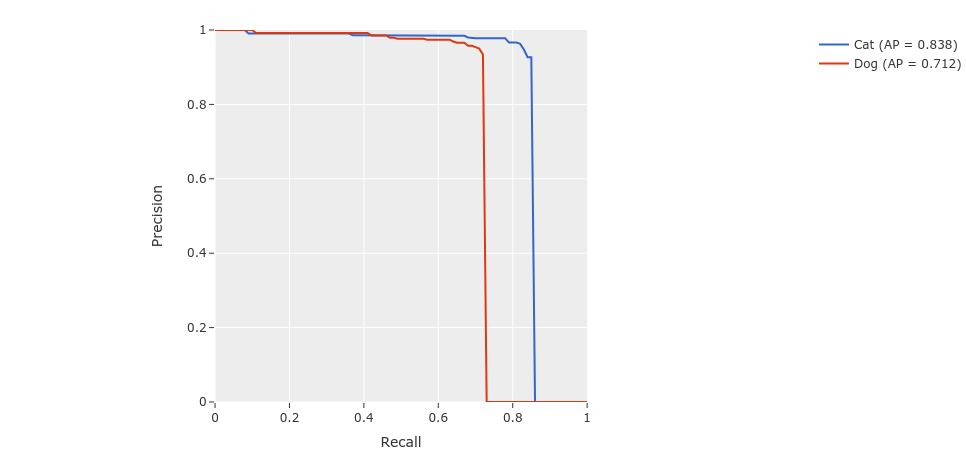

In [25]:
plot = results.plot_pr_curves()
plot.show()

In [26]:
plot.freeze()


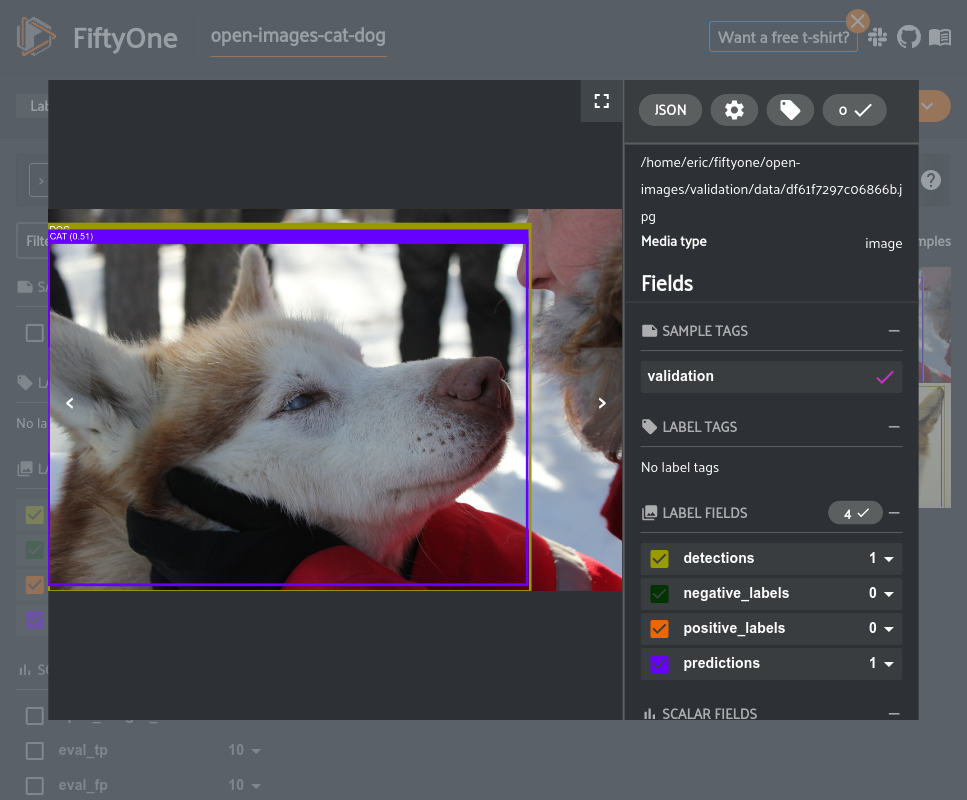

In [26]:
session = fo.launch_app(view=eval_view)

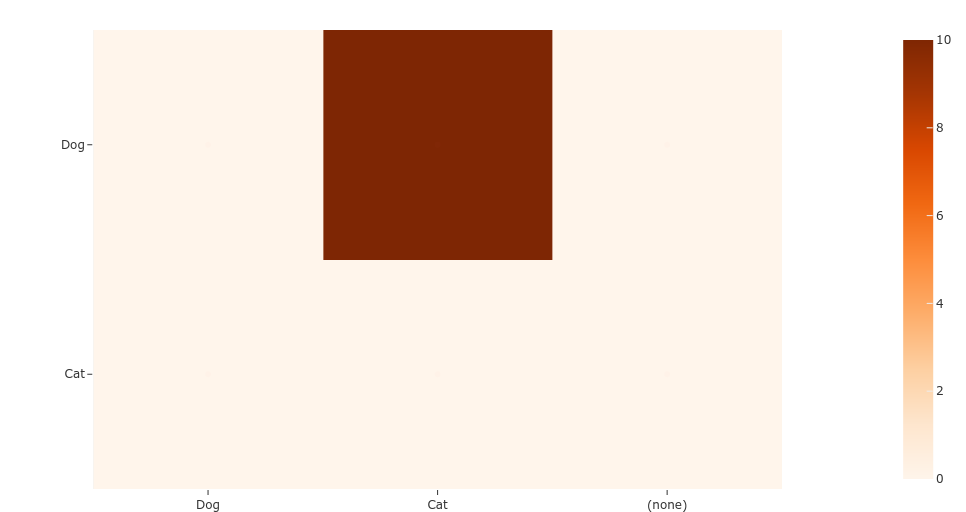

In [27]:
plot = results.plot_confusion_matrix(classes=["Dog", "Cat"])
plot.show(height=512)

Note: Since we decided to evaluate with `classwise=False`, the off-diagonal elements of the confusion matrix are populated with instances where the model prediction was matched with a ground truth of a different class.

Thanks to the [interactive plotting in FiftyOne](https://voxel51.com/docs/fiftyone/user_guide/plots.html#attaching-plots), we can [attach this plot](https://voxel51.com/docs/fiftyone/user_guide/plots.html#attaching-plots-to-the-app) back to the session object so that when you [click a cell of the confusion matrix](https://voxel51.com/docs/fiftyone/user_guide/plots.html#confusion-matrices), the session will be updated to show the relevant samples.

For example, if we click the top right cell, the session will be updated to only show the examples where a dog was predicted as a cat.

In [28]:
# If you are in a Jupyter notebook, attach plot to session
session.plots.attach(plot)

Note: Interactive plotting currently works in Jupyter notebooks only, but will soon be available in all environments in a future release.

In [21]:
session.freeze()  # screenshot app and plots for sharing

When running `evaluate_detections`, specifying an `eval_key` for evaluation will store true positive, false positive, and false negative labels on relevant ground truth and predicted objects. The `eval_key` in this example was set to `"eval"`.

It also stores the id of the matched ground truth object and the IoU of the match under `<eval-key>_id` and `<eval-key>_iou`.

In [30]:
print(eval_view.first().predictions.detections[0])

<Detection: {
    'id': '6078844e875a16649c7d833a',
    'attributes': BaseDict({}),
    'tags': BaseList([]),
    'label': 'Cat',
    'bounding_box': BaseList([
        0.2866099774837494,
        0.016059309244155884,
        0.7075197994709015,
        0.9593277871608734,
    ]),
    'mask': None,
    'confidence': 0.9282136559486389,
    'index': None,
    'eval_iou': 0.9482684065732272,
    'eval_id': '6078838d875a16649c7d5d78',
    'eval': 'tp',
}>


### Advanced dataset exploration

FiftyOne allows you to easily explore any fields that you have on your dataset both through code by creating a [view](https://voxel51.com/docs/fiftyone/user_guide/using_views.html) and through the [App](https://voxel51.com/docs/fiftyone/user_guide/app.html).

For example, we can find all instances of a dog or cat prediction above a confidence of 0.7 sorted by the number of true positives in the sample.

When doing this through the [App](https://voxel51.com/docs/fiftyone/user_guide/app.html), we just need to click "add stage", select `SortBy` and enter the field `eval_tp` with `reverse=True`. Then click the down arrow next to the field we want to [filter](https://voxel51.com/docs/fiftyone/user_guide/using_views.html#filtering) and type in the labels we want to include (cat and dog). If we are looking through predictions, we can also filter objects by confidence (move the slider to threshold confidence to 0.7).


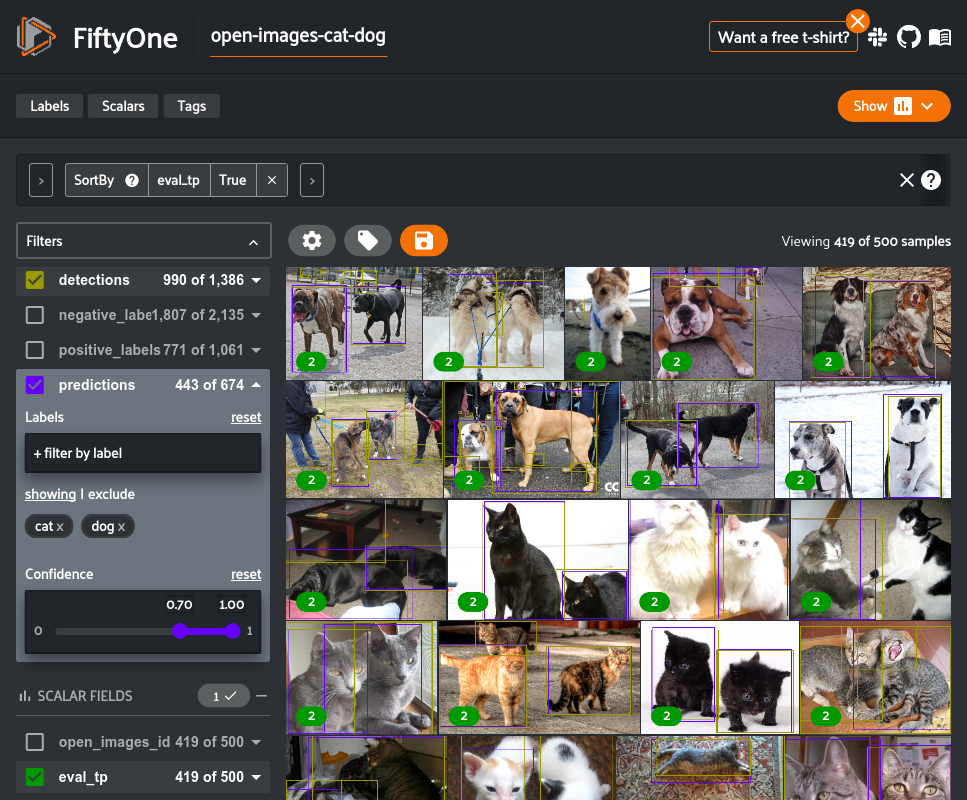

In [31]:
session = fo.launch_app(dataset)

In [32]:
session.freeze()

We can perform the same [filtering through views](https://voxel51.com/docs/fiftyone/user_guide/using_views.html#filtering) in the code.

In [33]:
dog_cat_view = (
    dataset
    .filter_labels(
        "predictions", 
        (
            (F("label").is_in(["dog", "cat"])) 
            & 
            (F("confidence") > 0.7)
        )
    ).sort_by("eval_tp", reverse=True)
)

In [34]:
dog_cat_view

Dataset:        open-images-cat-dog
Media type:     image
Num samples:    419
Tags:           ['validation']
Sample fields:
    filepath:        fiftyone.core.fields.StringField
    tags:            fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:        fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    positive_labels: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classifications)
    negative_labels: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classifications)
    detections:      fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    open_images_id:  fiftyone.core.fields.StringField
    predictions:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    eval_tp:         fiftyone.core.fields.IntField
    eval_fp:         fiftyone.core.fields.IntField
    eval_fn:         fiftyone.core.fields.IntField
View stages:
    1. FilterLabels(f


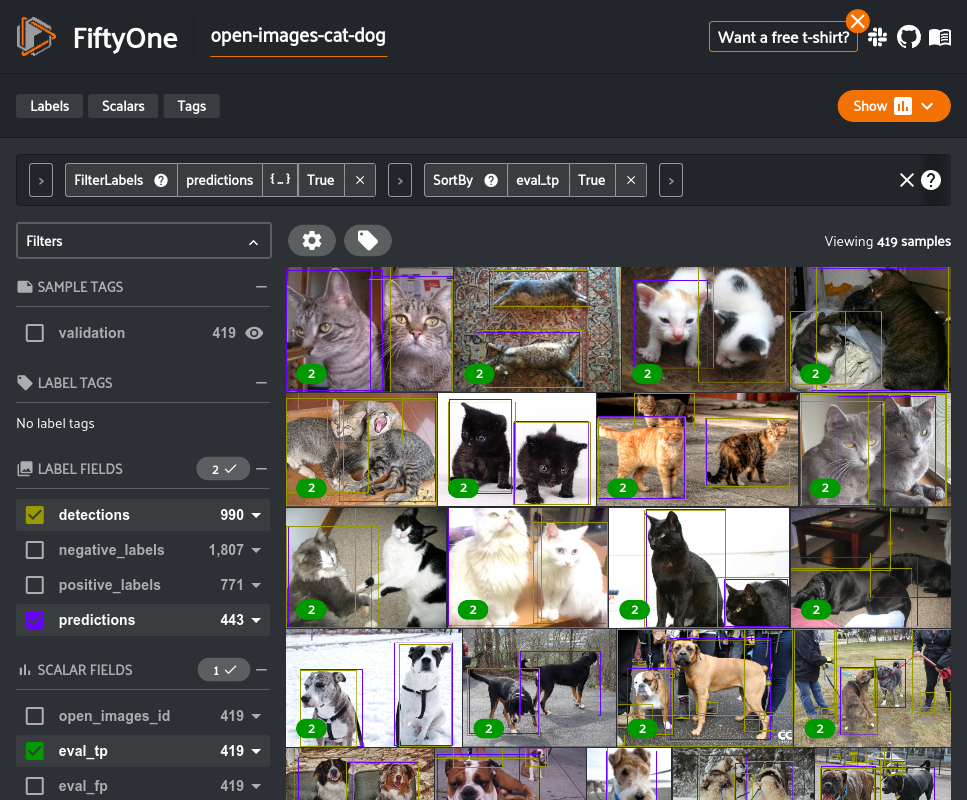

In [35]:
session.view = dog_cat_view

In [36]:
session.freeze()

These views are easy to use but can be incredibly useful to explore and query your dataset and model predictions.

For example, we can find all high confidence predictions of "Dog" that ended up being false positives.

In [37]:
fp_dog_view = dataset.filter_labels(
    "predictions", 
    (
        (F("eval") == "fp") 
        & 
        (F("confidence") > 0.9)
    )
)


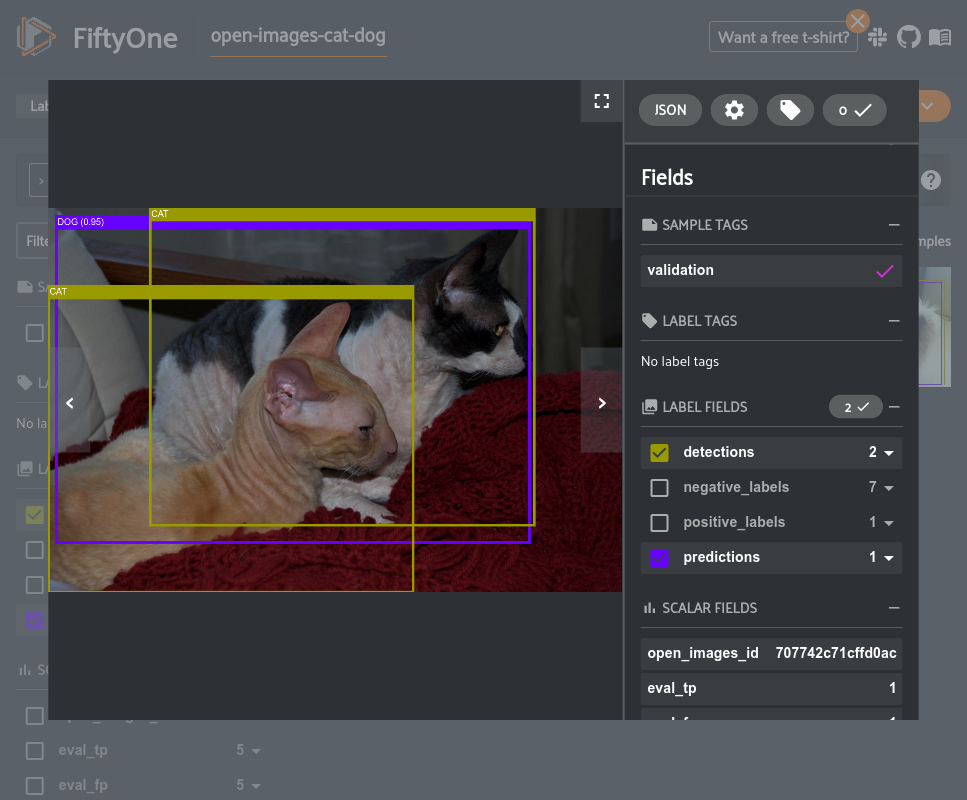

In [38]:
session.view = fp_dog_view

In [41]:
session.freeze()

Looking through some of these examples, we can see that when the model confuses dogs for cats roughly the same amount as cats for dogs. Additionally, the model occasionally has issues localizing bounding boxes resulting in unmatched detections due to an IoU lower than 0.5. 

In the example above, there are two ground truth cat boxes and one detected dog box containing both cats. This implies that we should look more closely at our training data to verify that there are no cats mistakenly annotated as dogs and that the boxes are localized properly.


### Visualize embeddings

FiftyOne is designed to make it as easy as possible for you to be able to explore your dataset, however, it also lets you get deeper insights beyond the [labels and attributes that you add to the dataset yourself](https://voxel51.com/docs/fiftyone/user_guide/using_datasets.html#adding-fields-to-a-sample).

FiftyOne provides the capability to [automatically generate embeddings](https://voxel51.com/docs/fiftyone/tutorials/image_embeddings.html) (both sample- and object-level) that you can interactively explore in unison with the App.

It only takes a few lines of code to generate embeddings on your data and plot visualizations of them together with informative labels from your dataset.

For example, let's compute embeddings on our detections and color them based on if they contain a dog or a cat.

We can use models from the [FiftyOne Model Zoo](https://voxel51.com/docs/fiftyone/user_guide/model_zoo/index.html) to compute embeddings on samples or image patches in just one line of code.

In [3]:
dataset.compute_metadata()

model = foz.load_zoo_model("mobilenet-v2-imagenet-tf1")

# Embed predicted patches
embeddings = eval_view.compute_patch_embeddings(
    model,
    "predictions",
)

 100% |█████████████████| 500/500 [27.9s elapsed, 0s remaining, 19.0 samples/s]      


The [FiftyOne Brain](https://voxel51.com/docs/fiftyone/user_guide/brain.html#fiftyone-brain) is a closed source extension to FiftyOne providing methods like [computing sample uniqueness](https://voxel51.com/docs/fiftyone/user_guide/brain.html#image-uniqueness), [finding annotation mistakes](https://voxel51.com/docs/fiftyone/user_guide/brain.html#label-mistakes), or [determining hardness](https://voxel51.com/docs/fiftyone/user_guide/brain.html#sample-hardness). It also provides a way to [visualize embeddings](https://voxel51.com/docs/fiftyone/user_guide/brain.html#visualizing-embeddings) in a low dimensional view.

In [4]:
import fiftyone.brain as fob

results = fob.compute_visualization(
    eval_view,
    patches_field = "predictions",
    embeddings=embeddings,
    num_dims=2,
    method="umap",
    verbose=True,
    seed=51,
)

Generating visualization...
UMAP(dens_frac=0.0, dens_lambda=0.0, random_state=51, verbose=True)
Construct fuzzy simplicial set
Thu Apr 15 14:34:48 2021 Finding Nearest Neighbors
Thu Apr 15 14:34:52 2021 Finished Nearest Neighbor Search
Thu Apr 15 14:34:55 2021 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Apr 15 14:34:58 2021 Finished embedding



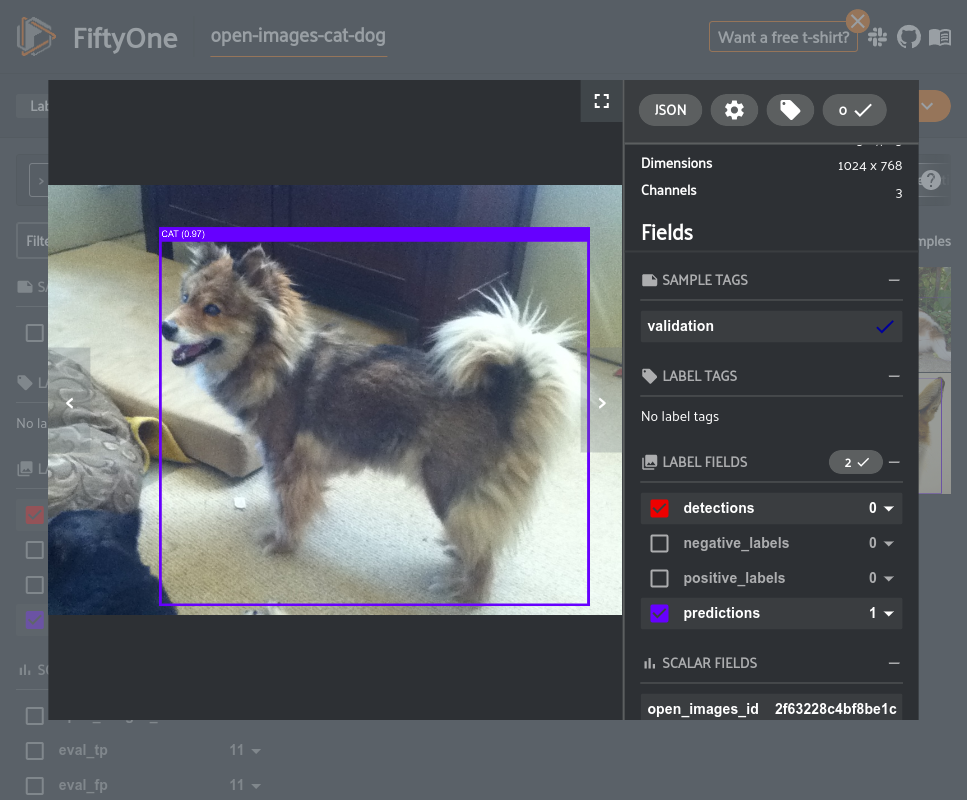

In [5]:
session = fo.launch_app(view=eval_view)

Now let's visualize the embeddings by label, with each point scaled by the size of the bounding box.

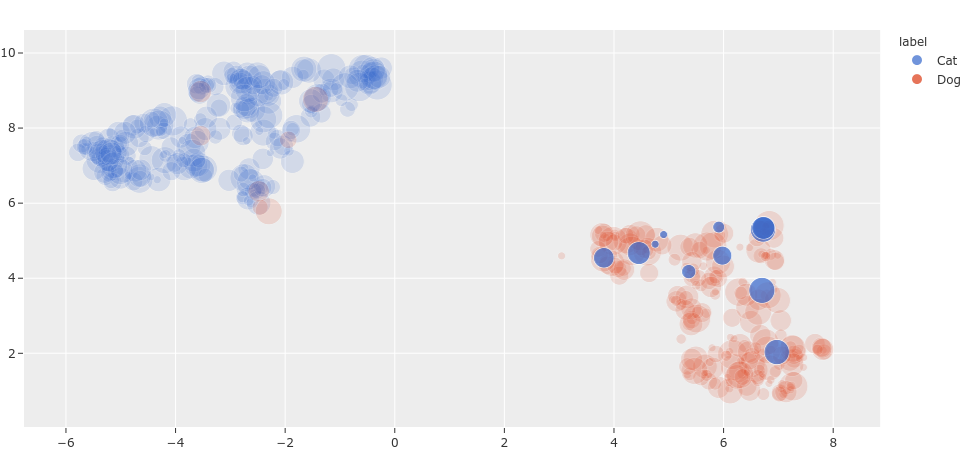

In [6]:
bbox_area = F("bounding_box")[2] * F("bounding_box")[3]
areas = eval_view.values("predictions.detections[]", bbox_area)

plot = results.visualize(
    labels="predictions.detections.label",
    sizes = areas,
)
plot.show()

Note: These plots are currently only interactive in Jupyter notebooks. A future release will provide interactive plots in all environments.

In [7]:
# If you are in a Jupyter notebook, attach plot to session
session.plots.attach(plot)

In [8]:
session.freeze()

Click the lasso tool on the plot to select a region of points that you want to visualize in the App.

You can clearly see the cat detections delinated from the dog detections. If you click the red circle next to "Dog", you will see only the "Cat" points. You can then lasso the cluster of "Cat" points that reside in the "Dog" embedding space. These points are the false positives that the model predicted as "Cat" but were infact dogs.


This kind of visiualization can be invaluable for a multitude of reasons, but especially for a dataset like Open Images that contains machine-generated labels. Visualizing and interactively exploring embeddings lets you quickly spot check which machine-generated labels may need to be reviewed and sent off for reannotation.

### Tagging

These interactive plots and embeddings can lead to valuable workflows like semi-supervised annotation, removing duplicates, detecting annotation mistakes, and much more.

For example, Open Images contains a class for "Cattle". However, this class contains animals like cows, sheep, and goats. We can use embeddings to cluster the embeddings for "Cattle" and [tag](https://voxel51.com/docs/fiftyone/user_guide/app.html#tags-and-tagging) each cluster of animals.

In [9]:
dataset = foz.load_zoo_dataset(
    "open-images", 
    "test", 
    label_types=["detections"], 
    classes = ["Cattle"],
    max_samples=200,
    seed=51,
    shuffle=True,
    dataset_name="open-images-cattle",
)

 100% |█████████████████| 200/200 [25.7s elapsed, 0s remaining, 9.2 samples/s]      
Found 200 samples
Dataset info written to '~/fiftyone/open-images/info.json'
Loading 'open-images' split 'test'
 100% |█████████████████| 200/200 [4.4s elapsed, 0s remaining, 48.3 samples/s]       
Dataset 'open-images-cattle' created


In [10]:
from fiftyone import ViewField as F

cattle_view = dataset.filter_labels("detections", F("label") == "Cattle")

In [11]:
dataset.compute_metadata()

model = foz.load_zoo_model("resnet-v2-50-imagenet-tf1")

# Embed predicted patches
embeddings = cattle_view.compute_patch_embeddings(
    model,
    "detections",
)

 100% |█████████████████| 200/200 [3.9s elapsed, 0s remaining, 53.8 samples/s]       
 100% |█████████████████| 200/200 [44.5s elapsed, 0s remaining, 3.8 samples/s]      


In [12]:
import fiftyone.brain as fob

results = fob.compute_visualization(
    cattle_view,
    patches_field = "detections",
    embeddings=embeddings,
    num_dims=2,
    method="umap",
    verbose=True,
    seed=51,
)

Generating visualization...
UMAP(dens_frac=0.0, dens_lambda=0.0, random_state=51, verbose=True)
Construct fuzzy simplicial set
Thu Apr 15 14:37:53 2021 Finding Nearest Neighbors
Thu Apr 15 14:37:53 2021 Finished Nearest Neighbor Search
Thu Apr 15 14:37:53 2021 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Apr 15 14:37:55 2021 Finished embedding



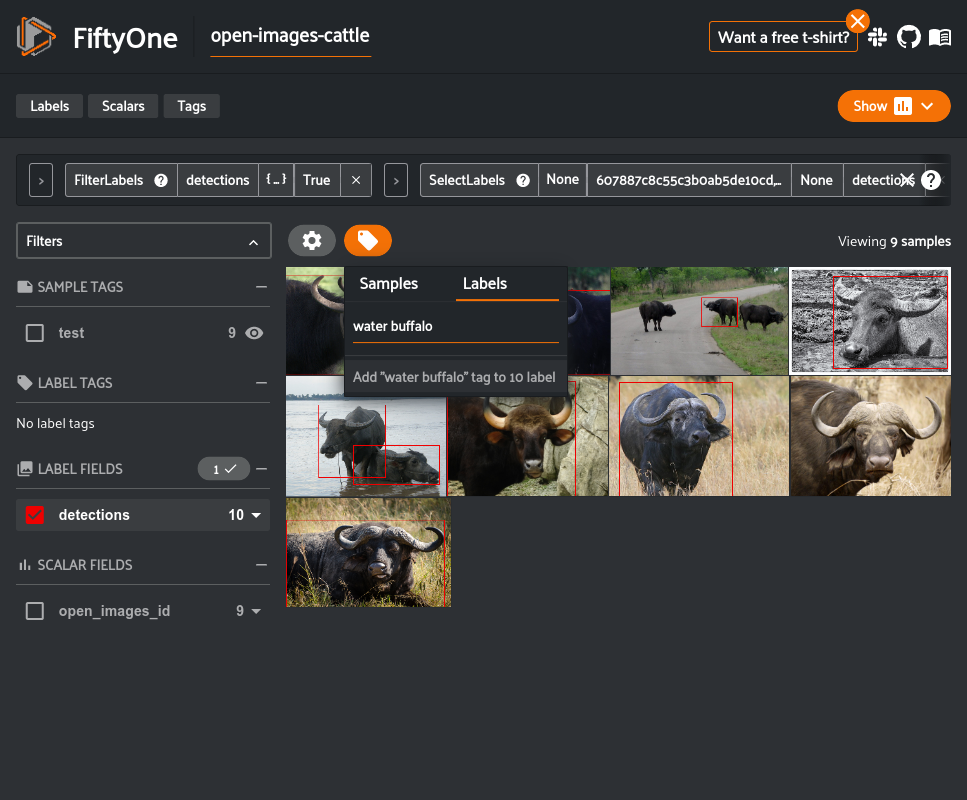

In [13]:
session = fo.launch_app(view=cattle_view)

Now let's visualize the embeddings by label, with each point scaled by the size of the bounding box.

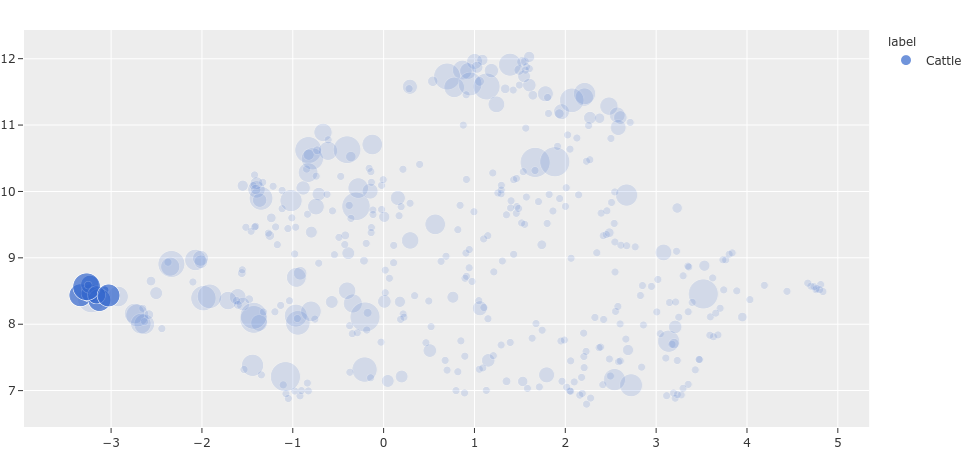

In [14]:
bbox_area = F("bounding_box")[2] * F("bounding_box")[3]
areas = cattle_view.values("detections.detections[]", bbox_area)

plot = results.visualize(
    labels="detections.detections.label",
    sizes = areas,
)
plot.show()

Note: These plots are currently only interactive in Jupyter notebooks. A future release will provide interactive plots in all environments.

In [15]:
# If you are in a Jupyter notebook, attach plot to session
session.plots.attach(plot)

In [16]:
session.freeze()

Click the lasso tool on the plot to select a region of points that you want to visualize in the App.

You can produce different embeddings based on the model that you choose, either from other models in the zoo or embeddings that you compute from a model yourself. Generally, deeper models will produce embeddings clusters based more off of the high-level concepts in the image rather than low-level features like color.

Once we have a set of samples that we [want to tag](https://voxel51.com/docs/fiftyone/user_guide/app.html#tags-and-tagging), we click the tag icon in the App and add a new custom tag either to all samples or labels currently visualized. From here, we can [export these subsets](https://voxel51.com/docs/fiftyone/user_guide/export_datasets.html) and send them to annotators for verification and relabeling.

## Summary

This walkthrough has shown you how to download, explore, and evaluate Open Images and your models with FiftyOne. In particular, we covered:

* Downloading [Open Images](https://storage.googleapis.com/openimages/web/index.html) from the [FiftyOne Dataset Zoo](https://voxel51.com/docs/fiftyone/user_guide/dataset_zoo/index.html)
* Computing predictions with the [FiftyOne Model Zoo](https://voxel51.com/docs/fiftyone/user_guide/model_zoo/index.html)
* Using [Open Images object detection evaluation](https://storage.googleapis.com/openimages/web/evaluation.html) in FiftyOne to evaluate a model
* Exploring the dataset and evaluation results
* [Visualizing embeddings](https://voxel51.com/docs/fiftyone/user_guide/brain.html#visualizing-embeddings) through [interactive plots](https://voxel51.com/docs/fiftyone/user_guide/plots.html)


**So, what's the takeaway?**

Open Images is a massive thoroughly labeled dataset that can make a useful addition to your data lake and model training workflows. The easiest way to download and explore Open Images is with the FiftyOne. 

Hands-on evaluation of your model results is often difficult, but FiftyOne makes it easy to find failure modes in your model and even take one step further to reveal patterns in your data by visualizing embeddings.